## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from tqdm import tqdm, trange
import wandb
import networkx as nx

from LS_Algorithm import get_nme

## Initialization and supplementary functions

In [2]:
def adj_matrix(G):
    '''
    creates adj and neigbors:
    adj: 2D adjacency matrix of a graph
    neighbors: list of lists of neighbors (indexes from 0 to N-1, where N is a number of nodes)
    '''
    adj = nx.to_numpy_array(G)

    neighbors = []
    for i in range(nx.number_of_nodes(G)):
        neighbors_ = [neighbor for neighbor in nx.neighbors(G, i)]
        neighbors.append(neighbors_)
    return adj, neighbors

adjacency matrix
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]
neigbors
[[1], [0, 9], [12], [13, 20], [10, 18], [21, 27], [15], [16], [11], [1, 17], [4, 14], [8, 16], [2, 13], [3, 12], [10], [6, 16, 35, 51, 55], [7, 11, 15, 41], [9, 22, 28], [4], [24], [3, 23], [5], [17, 29], [20, 24], [19, 23, 31], [27, 34, 38], [32], [5, 25], [17, 29, 32], [22, 28, 30, 32], [29, 31, 33, 40], [24, 30, 33], [26, 28, 29, 43, 66], [30, 31], [25], [15, 39], [42, 43], [38, 45, 47], [25, 37], [35, 49, 50], [30, 44, 46, 60], [16, 56], [36, 43], [32, 36, 42, 58], [40, 45, 54], [37, 44, 47], [40, 52, 53], [37, 45], [49, 61], [39, 48, 50, 63], [39, 49], [15, 55], [46, 53, 59], [46, 52], [44, 67], [15, 51, 64, 75, 84, 97], [41, 64, 65, 71], [], [43, 69], [52], [40, 67, 68], [48], [65], [49, 70], [55, 56, 71, 83], [56, 62], [32, 69, 73, 76, 78, 80], [54, 60, 74], [60, 73], [58, 66, 72], [63], [56, 64], [6

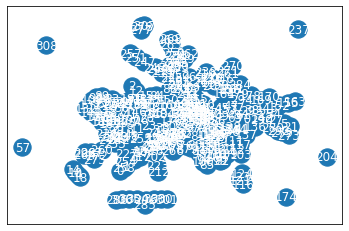

In [3]:
# example of the file with graph data:
ks = 2 #coarse_graining grid size
G = nx.read_gpickle(f"pore_network_0{ks}.gpickle")
rng = np.random.RandomState(42)


adj, neighbors = adj_matrix(G)
print('adjacency matrix')
print(adj)
print('neigbors')
print(neighbors)
nx.draw_networkx(G, with_labels=True, font_color='white')

In [4]:
def system_initialization(G, N_sensors):
    '''
    - Uses previously stated function adj_matrix to initialize 
    all needed information about graph
    - Initializes sensors positions
    ----------------------------------
    G: graph
    adj: adjacency matrix
    N_sensors: number of sensors
    sensors: ndarray of sensors' indexes 
    '''
    n = nx.number_of_edges(G)
    N_nodes = nx.number_of_nodes(G)

    adj, neighbors = adj_matrix(G)
    sensors = np.array([(N_nodes*i)//N_sensors for i in range(N_sensors)])

    return adj, neighbors, sensors

## Metropolis algorithm

In [43]:
def step(sensors, E_tot, Statistics, neighbors, adj):
    '''
    one step of a Metropolis algorithm cycle:

    1. shifts one random sensor to the neigboring node
    2. calculates the difference in energy
    3. accepts\rejects new location of the sensor
    '''

    # choose the random sensor
    choice = rng.choice
    old_sensor_number = choice(np.arange(N_sensors))
    old_node_number = sensors[old_sensor_number]

    # skip to the next step if there are no neighbors
    if len(neighbors[old_node_number]) == 0:
        # no neighbors
        Statistics[0] +=1 
        return sensors, E_tot, Statistics

    # choose the random neighboring node of the chosen one
    num_of_neighbors = len(neighbors[old_node_number])
    neighboring_loc = choice(np.arange(num_of_neighbors))
    new_node_number = neighbors[old_node_number][neighboring_loc]

    # skip to the next step if the chosen node is occupied
    if new_node_number in sensors:
        Statistics[1] +=1
        return sensors, E_tot, Statistics

    #shift the sensor
    # sensors_new = np.delete(sensors, old_sensor_number) 
    # sensors_new = np.append(sensors_new, new_node_number)
    sensors_new = sensors.copy()
    sensors_new[old_sensor_number] = new_node_number
    # calculate the difference in energy
    E_new = get_nme(sensors_new, ks, G)
    dE = E_new - E_tot
    # accept/reject
    dp = np.exp(-dE/T)
    rand = rng.random()
    wandb.log({'E/random': rand, 'E/acceptance probability': dp}, commit=False)
    if dp > rand:
        # accept
        E_tot = E_new
        Statistics[2] +=1
        return sensors_new, E_tot, Statistics
    else:
        # reject
        #return the sensor back
        Statistics[3] +=1
        return sensors, E_tot, Statistics

In [44]:
def cycle(sensors, E_tot, neighbors, adj, steps):
    '''
    cycle of metropolis algorithm's steps
    stores information about energy levels during the simulation
    '''

    Statistics = np.array([0.,  # 'no_neighbors'
                        0.,  # 'occupied'
                        0.,  # 'accepted'
                        0.]) # 'rejected'

    best_sensor_loc = sensors.copy()
    E_min = E_tot
    # best_step = 0


    for i in trange(1,steps+1):
        sensors, E_tot, Statistics = step(sensors, E_tot, 
                                          Statistics, neighbors, adj)
        if E_tot < E_min:
            best_sensor_loc = sensors.copy()
            
            E_min = E_tot
            # best_step = i
            wandb.log({'E/Emin': E_min, 'Best sensor location': best_sensor_loc}, commit=False)
        
        wandb.log({'E/E': E_tot, 'Statistics/no_neighbors':Statistics[0], 'Statistics/occupied':Statistics[1], 
                   'Statistics/accepted':Statistics[2], 'Statistics/rejected':Statistics[3]})
        
    Statistics /= steps
    return sensors, E_tot, Statistics,\
           best_sensor_loc, E_min

In [45]:
def simulation(adj, neighbors, sensors, steps):
    '''
    does the simulation and returns numerical results
    '''
    E_tot = get_nme(sensors, ks, G)
    sensors, E_tot, Statistics, best_sensor_loc, E_min =\
        cycle(sensors, E_tot, neighbors, adj, steps)
    print(f'E min: {E_min}\n best location:{best_sensor_loc}')
    # verification of right energy calculation
    E_fin = get_nme(sensors, ks, G)
    assert np.isclose(E_fin, E_tot), f'E_fin={E_fin}, E_tot={E_tot}'

    return sensors, Statistics, \
           best_sensor_loc, E_min

In [48]:
wandb.init()
hyperparameter_defaults = dict(
    T=1,
    N_sensors=200,
    steps = 10**3
    )
wandb.init(config=hyperparameter_defaults)
config = wandb.config
T = config.T
N_sensors = config.N_sensors
steps = config.steps
adj, neighbors, sensors = system_initialization(G, N_sensors)
sensors, Statistics, best_sensor_loc, E_min =\
    simulation(adj, neighbors, sensors, steps)

data = {"best_location":best_sensor_loc}
df = pd.DataFrame(data)
best_loc_table = wandb.Table(data=df)
wandb.log({'best location table':best_loc_table}, commit=False)

E/E,▃▃▃▃▃▃▁▃▃▃▃▃▃▃▃▂▁▁▃▃▁▄▆▆▃▁▂█▃▂▂▂▂█▃▃▃▂▃▂
E/Emin,▇██▇▄▄▇▆▆▆▆▆▅▃▁▁
E/acceptance probability,▆▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▄▆█▄▆▆▆▆▆▁▆▆▆▆▆▇▆▆▄▆▆▆
E/random,▅▁▃▅█▆▃▅▄▆▄▅▅▆█▆▅▆▇▇█▃▁▆█▁▄▇▇▇▆▅▄▃▆▄█▁▆▆
Statistics/accepted,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Statistics/no_neighbors,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Statistics/occupied,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███████
Statistics/rejected,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████
E/E,0.12205
E/Emin,0.10455
E/acceptance probability,1.00269


100%|███████████████████████████████████████| 1000/1000 [31:48<00:00,  1.91s/it]


E min: 0.008021585643291473
 best location:[  0   1   3   4   6   7   9  10   2  12  15  17  18  20  21  23  24  26
  27  29  30  32  34  35  37  25  46   8  43  40  53  49  39  55  52  54
  84  57  59  67  62  63  65  78  60  69  71  73  74  80  77  79 120  82
  92  85 106  88  83  91  93  94  96  75  99 101 102 104 105 107 108 109
 103 113 115 116 114 119 121 111 124 125 127 129 130 148 133 135 136 138
 139 128 143 144 146 147 149 150 152 153 155 157 154 165 168 163 164 166
 156 169 173 172 174 175 180 179 184 181 183 185 193 187 198 176 192 194
 195 197 199 200 191 203 196 161 208 209 215 213 207 216 202 210 238 225
 223 229 227 228 274 235 260 234 236 237 239 240 242 244 245 247 248 263
 251 253 243 265 254 259 246 262 264 266 267 268 271 272 279 275 276 277
 280 281 288 284 286 287 289 290 292 293 282 297 298 300 301 303 296 305
 278 310]


NameError: name 'best_step' is not defined